### Prerequisite: 
Python 2.7.x, 3.5.x, or 3.6.x

### Install dependencies (prepending with `sudo` if needed):
```
pip install requests
pip install tabulate
pip install "colorama>=0.3.8"
pip install future 
```

### The following command removes the H2O module for Python.
```
pip uninstall h2o
```

### Next, use pip to install this version of the H2O Python module.
```
pip install http://h2o-release.s3.amazonaws.com/h2o/rel-yates/2/Python/h2o-3.24.0.3-py2.py3-none-any.whl
```
### or with Anaconda
```
conda install -c h2oai h2o
```

In [1]:
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"

     |################################| 51kB 115kB/s ta 0:00:0101
  Stored in directory: /root/.cache/pip/wheels/2b/67/89/414471314a2d15de625d184d8be6d38a03ae1e983dbda91e84
Successfully built tabulate


In [2]:
!pip install future 
!pip uninstall h2o


     |################################| 829kB 198kB/s eta 0:00:01
  Stored in directory: /root/.cache/pip/wheels/0c/61/d2/d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
Successfully built future


In [3]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     |################################| 123.6MB 453kB/s eta 0:00:01
  Stored in directory: /root/.cache/pip/wheels/b2/f3/a4/4eae0227dcbbf0383d1efe78982b09c11c54fe509ab5180c32
Successfully built h2o


## Init H2O

In [4]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...


H2OStartupError: Cannot find Java. Please install the latest JRE from
http://www.oracle.com/technetwork/java/javase/downloads/index.html

## Classification with Chicago Crime Dataset

In [5]:
chicago_crime = h2o.get_frame("chicago.crime.hex")
if chicago_crime is None:
    chicago_crime = h2o.import_file(
        "https://s3.amazonaws.com/h2o-public-test-data/smalldata/chicago/chicagoCrimes10k.csv.zip",
        destination_frame = "chicago.crime.hex")
chicago_crime.dim

Parse progress: |█████████████████████████████████████████████████████████| 100%


[9999, 22]

In [6]:
chicago_crime.col_names

['ID',
 'Case Number',
 'Date',
 'Block',
 'IUCR',
 'Primary Type',
 'Description',
 'Location Description',
 'Arrest',
 'Domestic',
 'Beat',
 'District',
 'Ward',
 'Community Area',
 'FBI Code',
 'X Coordinate',
 'Y Coordinate',
 'Year',
 'Updated On',
 'Latitude',
 'Longitude',
 'Location']

In [0]:
y = 'Arrest'
x = chicago_crime.col_names
x.remove(y)
x = [el for el in x if el not in ['Case Number','Block','Description', 'Location Description','Date','Updated On']]

### Logistic Regression Model

In [8]:
# Train GLM Classifier
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

glm_crime_model = H2OGeneralizedLinearEstimator(family = "binomial", nfolds = 3, seed = 75205)
glm_crime_model.train(x, y, training_frame = chicago_crime, model_id = "glm_crime_py_model")

glm Model Build progress: |███████████████████████████████████████████████| 100%


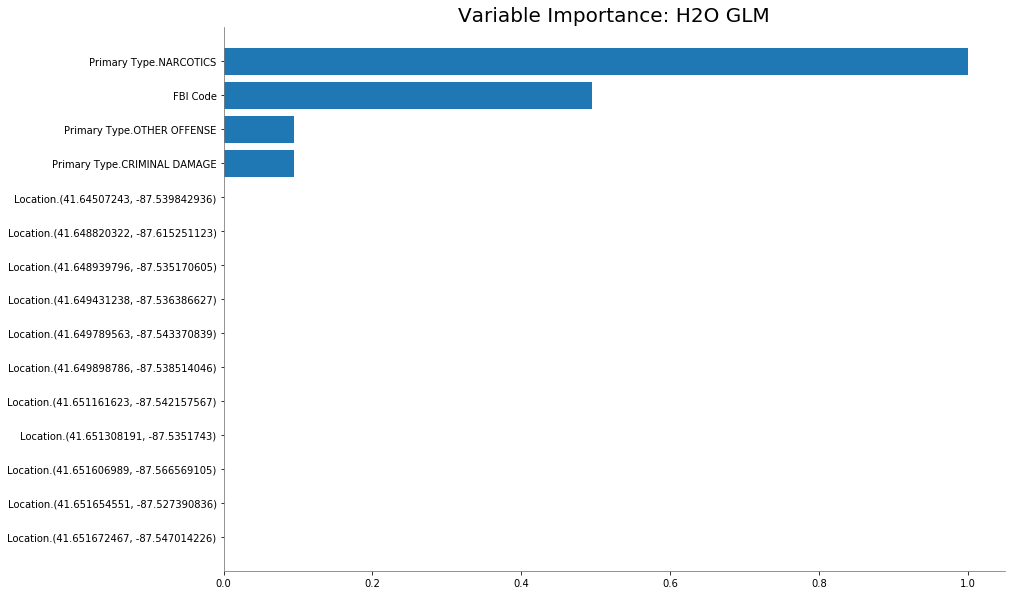

In [9]:
glm_crime_model.varimp_plot(15)

In [10]:
print("Validation AUC (3-fold CV): " + str(glm_crime_model.auc(xval = True)))
print("Accuracy (3-fold CV): " + str(glm_crime_model.accuracy(xval = True)))

Validation AUC (3-fold CV): 0.7982668762504898
Accuracy (3-fold CV): [[0.5917761503957594, 0.8191819181918192]]


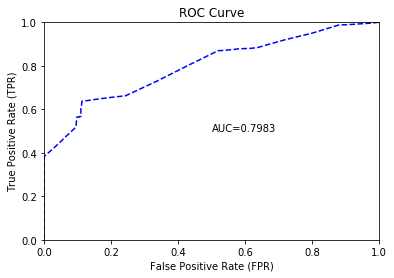

In [11]:
glm_crime_model.model_performance(xval=True).plot()

In [12]:
glm_crime_model.confusion_matrix(xval = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28705932089852026: 


,false,true,Error,Rate
false,6272.0,799.0,0.113,(799.0/7071.0)
true,1064.0,1864.0,0.3634,(1064.0/2928.0)
Total,7336.0,2663.0,0.1863,(1863.0/9999.0)


### Random Forest Model

In [13]:
from h2o.estimators.random_forest import H2ORandomForestEstimator

rf_crime_model = H2ORandomForestEstimator(nfolds = 3, seed = 75205)
rf_crime_model.train(x, y, training_frame = chicago_crime, model_id = "rf_crime_py_model")

drf Model Build progress: |███████████████████████████████████████████████| 100%


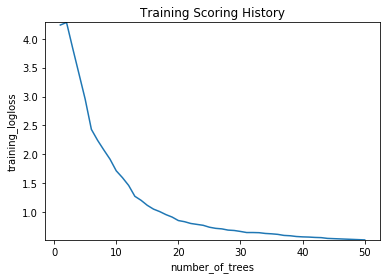

In [14]:
rf_crime_model.plot()

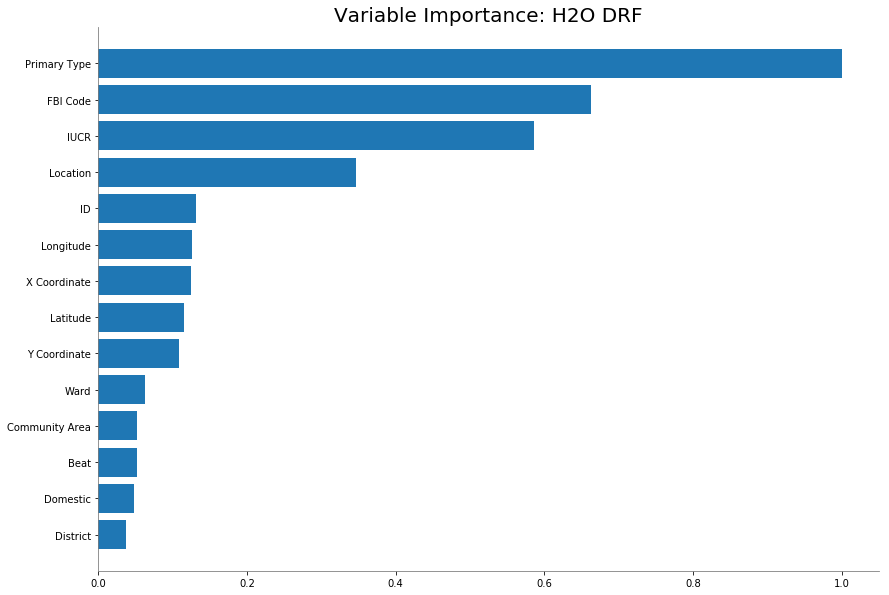

In [15]:
rf_crime_model.varimp_plot(15)

### Random Forest Performance

In [16]:
print("Validation AUC (3-fold CV): " + str(rf_crime_model.auc(xval = True)))
print("Accuracy (3-fold CV): " + str(rf_crime_model.accuracy(xval = True)))

Validation AUC (3-fold CV): 0.9056166648505827
Accuracy (3-fold CV): [[0.4667221318682035, 0.8815881588158816]]


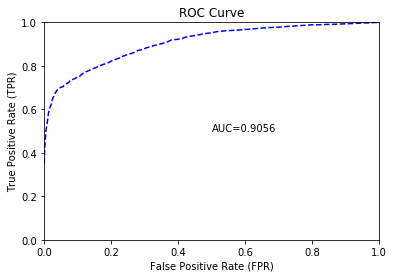

In [17]:
rf_crime_model.model_performance(xval=True).plot()

In [18]:
rf_crime_model.confusion_matrix(xval = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4599451684100287: 


,false,true,Error,Rate
false,6800.0,271.0,0.0383,(271.0/7071.0)
true,915.0,2013.0,0.3125,(915.0/2928.0)
Total,7715.0,2284.0,0.1186,(1186.0/9999.0)


### Train Classifiers Using H2O's AutoML

In [0]:
(chicago_crime_train, chicago_crime_test) = chicago_crime.split_frame(ratios = [.8], seed = 75205,
                                  destination_frames = ["chicago.crime.train", "chicago.crime.test"])

In [0]:
# optional - both already exist
chicago_crime_train = h2o.get_frame("chicago.crime.train")
chicago_crime_test = h2o.get_frame("chicago.crime.test")

In [21]:
from h2o.automl import H2OAutoML

aml_crime_model = H2OAutoML(max_runtime_secs = 60, nfolds = 3, seed = 75205,
                            include_algos = ['GLM','DRF','GBM'], 
                            project_name = "automl_crime_py_model",
                            keep_cross_validation_predictions = False,
                            keep_cross_validation_models = False,
                            keep_cross_validation_fold_assignment = False)
aml_crime_model.train(x = x, y = y, 
                      training_frame = chicago_crime_train, 
                      leaderboard_frame = chicago_crime_test)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [0]:
print(aml_crime_model.leaderboard)

model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_3_AutoML_20190719_201840,0.929651,0.283113,0.169622,0.294806,0.0869108
GBM_4_AutoML_20190719_201840,0.927428,0.28588,0.166618,0.296091,0.0876697
GBM_2_AutoML_20190719_201840,0.927372,0.284594,0.164365,0.295266,0.087182
GBM_1_AutoML_20190719_201840,0.925828,0.286396,0.170148,0.296949,0.0881785
GBM_5_AutoML_20190719_201840,0.924857,0.285586,0.155696,0.295926,0.0875721
DRF_1_AutoML_20190719_201840,0.911237,0.335902,0.184625,0.307097,0.0943085
XRT_1_AutoML_20190719_201840,0.900016,0.502234,0.174882,0.31037,0.0963298
GLM_grid_1_AutoML_20190719_201840_model_1,0.850402,0.380523,0.22881,0.341582,0.116678


### Best Model Performance

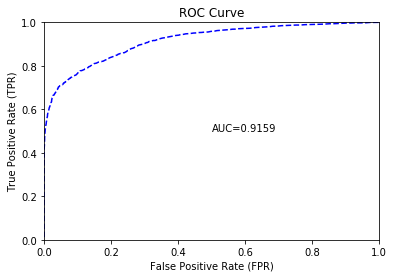

In [22]:
best_model = aml_crime_model.leader
best_model.model_performance(xval=True).plot()

## Regression Models with Wine Quality Dataset

In [23]:
wine_quality = h2o.get_frame("wine.hex")
if wine_quality is None:
    wine_quality = h2o.import_file("https://s3.amazonaws.com/h2o-public-test-data/smalldata/wine/winequality-redwhite.csv",
                               destination_frame = "wine.hex")
wine_quality.dim

Parse progress: |█████████████████████████████████████████████████████████| 100%


[6497, 13]

In [24]:
wine_quality.col_names

['\ufefffixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality',
 'type']

In [0]:
y = "quality"
x = wine_quality.col_names
x.remove(y)

### GLM Regression Model (Linear Model)

In [26]:
# Train GLM Regression
glm_wine_model = H2OGeneralizedLinearEstimator(family = "gaussian", nfolds = 3, seed = 75205)
glm_wine_model.train(x, y, training_frame = wine_quality, model_id = "glm_wine_py_model")

glm Model Build progress: |███████████████████████████████████████████████| 100%


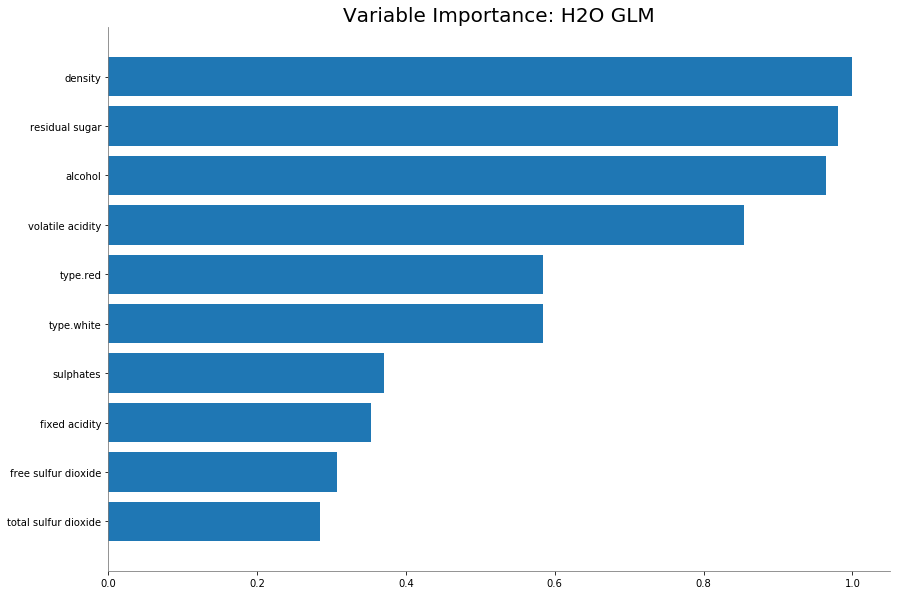

In [27]:
glm_wine_model.varimp_plot()

In [28]:
glm_wine_model.model_performance(xval = True)


ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 0.5413493210799418
RMSE: 0.7357644467354629
MAE: 0.5714590986708442
RMSLE: 0.10987641228848109
R^2: 0.28999400622440186
Mean Residual Deviance: 0.5413493210799418
Null degrees of freedom: 6496
Residual degrees of freedom: 6483
Null deviance: 4955.154860463656
Residual deviance: 3517.1465390563817
AIC: 14480.540035226095


### GBM Regression Model

In [29]:
from h2o.estimators import H2OGradientBoostingEstimator

xgb_wine_model = H2OGradientBoostingEstimator(nfolds = 3, seed = 75205)
xgb_wine_model.train(x, y, training_frame = wine_quality, model_id = "gbm_wine_py_model")

gbm Model Build progress: |███████████████████████████████████████████████| 100%


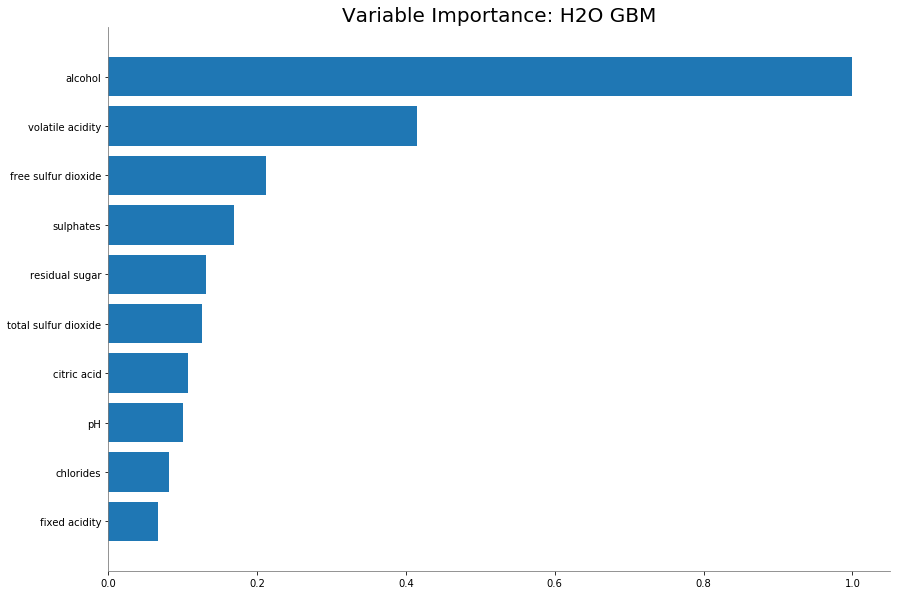

In [30]:
xgb_wine_model.varimp_plot()

In [31]:
xgb_wine_model.model_performance(xval = True)


ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.4576307679815389
RMSE: 0.6764841224903501
MAE: 0.5237261895840969
RMSLE: 0.10148727828362909
Mean Residual Deviance: 0.4576307679815389


### Train Regression Using H2O's AutoML

In [0]:
(wine_quality_train, wine_quality_test) = wine_quality.split_frame(ratios = [.8], seed = 75205,
                                  destination_frames = ["wine.quality.train", "wine.quality.test"])

In [0]:
# opitonal - both already exist
wine_quality_train = h2o.get_frame("wine.quality.train")
wine_quality_test = h2o.get_frame("wine.quality.test")

In [34]:
aml_wine_model = H2OAutoML(max_runtime_secs = 60, nfolds = 3, seed = 75205,
                            include_algos = ['GLM','DRF','GBM'], 
                            project_name = "automl_wine_py_model",
                            keep_cross_validation_predictions = False,
                            keep_cross_validation_models = False,
                            keep_cross_validation_fold_assignment = False)
aml_wine_model.train(x = x, y = y, 
                     training_frame = wine_quality_train, 
                     leaderboard_frame = wine_quality_test)

AutoML progress: |█████████████████████████████████████████████████████████| 100%


In [35]:
print(aml_wine_model.leaderboard)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
DRF_1_AutoML_20190720_100455,0.373424,0.611084,0.373424,0.427379,0.0945481
XRT_1_AutoML_20190720_100455,0.376333,0.61346,0.376333,0.428517,0.0950342
GBM_grid_1_AutoML_20190720_100455_model_2,0.409889,0.640226,0.409889,0.459596,0.0985485
GBM_4_AutoML_20190720_100455,0.411014,0.641104,0.411014,0.464847,0.0981984
GBM_3_AutoML_20190720_100455,0.429698,0.655513,0.429698,0.486848,0.10019
GBM_1_AutoML_20190720_100455,0.434578,0.659225,0.434578,0.495745,0.100615
GBM_grid_1_AutoML_20190720_100455_model_3,0.437989,0.661807,0.437989,0.495743,0.101345
GBM_2_AutoML_20190720_100455,0.438609,0.662276,0.438609,0.498043,0.101205
GBM_5_AutoML_20190720_100455,0.455433,0.674858,0.455433,0.506269,0.103169
GBM_grid_1_AutoML_20190720_100455_model_1,0.475251,0.689384,0.475251,0.516093,0.105639


In [36]:
# Use local data file or download from GitHub
import os
docker_data_path = "/home/h2o/data/automl/powerplant_output.csv"
if os.path.isfile(docker_data_path):
  data_path = docker_data_path
else:
  data_path = "https://github.com/h2oai/h2o-tutorials/raw/master/h2o-world-2017/automl/data/powerplant_output.csv"


# Load data into H2O
df = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


Let's take a look at the data.

In [37]:
df.describe()

Rows:9568
Cols:5




,TemperatureCelcius,ExhaustVacuumHg,AmbientPressureMillibar,RelativeHumidity,HourlyEnergyOutputMW
type,real,real,real,real,real
mins,1.81,25.36,992.89,25.56,420.26
mean,19.651231187290957,54.3058037207358,1013.2590781772578,73.30897784280936,454.36500940635455
maxs,37.11,81.56,1033.3,100.16,495.76
sigma,7.452473229611082,12.707892998326807,5.93878370581162,14.600268756728957,17.066994999803423
zeros,0,0,0,0,0
missing,0,0,0,0,0
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.4,1012.16,92.14,488.56


Next, let's identify the response column and save the column name as `y`.  In this dataset, we will use all columns except the response as predictors, so we can skip setting the `x` argument explicitly.

In [0]:
y = "HourlyEnergyOutputMW"

Lastly, let's split the data into two frames, a `train` (80%) and a `test` frame (20%).  The `test` frame will be used to score the leaderboard and to demonstrate how to generate predictions using an AutoML leader model.

In [0]:
splits = df.split_frame(ratios = [0.8], seed = 1)
train = splits[0]
test = splits[1]

## Run AutoML 

Run AutoML, stopping after 60 seconds.  The `max_runtime_secs` argument provides a way to limit the AutoML run by time.  When using a time-limited stopping criterion, the number of models train will vary between runs.  If different hardware is used or even if the same machine is used but the available compute resources on that machine are not the same between runs, then AutoML may be able to train more models on one run vs another. 

The `test` frame is passed explicitly to the `leaderboard_frame` argument here, which means that instead of using cross-validated metrics, we use test set metrics for generating the leaderboard.

In [40]:
aml = H2OAutoML(max_runtime_secs = 60, seed = 1, project_name = "powerplant_lb_frame")
aml.train(y = y, training_frame = train, leaderboard_frame = test)

AutoML progress: |████████████████████████████████████████████████████████| 100%


*Note: If you see the following error, it means that you need to install the pandas module.*
```
H2OTypeError: Argument `python_obj` should be a None | list | tuple | dict | numpy.ndarray | pandas.DataFrame | scipy.sparse.issparse, got H2OTwoDimTable 
``` 

For demonstration purposes, we will also execute a second AutoML run, this time providing the original, full dataset, `df` (without passing a `leaderboard_frame`).  This is a more efficient use of our data since we can use 100% of the data for training, rather than 80% like we did above.  This time our leaderboard will use cross-validated metrics.

*Note: Using an explicit `leaderboard_frame` for scoring may be useful in some cases, which is why the option is available.*  

In [0]:
aml2 = H2OAutoML(max_runtime_secs = 60, seed = 1, project_name = "powerplant_full_data")
aml2.train(y = y, training_frame = df)

AutoML progress: |████████████████████████████████████████████████████████| 100%


*Note: We specify a `project_name` here for clarity.*

## Leaderboard

Next, we will view the AutoML Leaderboard.  Since we specified a `leaderboard_frame` in the `H2OAutoML.train()` method for scoring and ranking the models, the AutoML leaderboard uses the performance on this data to rank the models.

After viewing the `"powerplant_lb_frame"` AutoML project leaderboard, we compare that to the leaderboard for the `"powerplant_full_data"` project.  We can see that the results are better when the full dataset is used for training.  

A default performance metric for each machine learning task (binary classification, multiclass classification, regression) is specified internally and the leaderboard will be sorted by that metric.  In the case of regression, the default ranking metric is mean residual deviance.  In the future, the user will be able to specify any of the H2O metrics so that different metrics can be used to generate rankings on the leaderboard.

In [41]:
aml.leaderboard.head()

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
XGBoost_1_AutoML_20190720_100627,11.1589,3.3405,11.1589,2.37046,0.00736514
StackedEnsemble_BestOfFamily_AutoML_20190720_100627,11.2318,3.35139,11.2318,2.39573,0.00739007
StackedEnsemble_AllModels_AutoML_20190720_100627,11.2435,3.35313,11.2435,2.39727,0.00739421
XGBoost_2_AutoML_20190720_100627,1529.74,39.1119,1529.74,38.7602,0.0894516


Now we will view a snapshot of the top models.  Here we should see the two Stacked Ensembles at or near the top of the leaderboard.  Stacked Ensembles can almost always outperform a single model.

In [0]:
aml2.leaderboard.head()

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
XGBoost_1_AutoML_20190718_000328,10.65,3.26344,10.65,2.36821,0.00717828
StackedEnsemble_BestOfFamily_AutoML_20190718_000328,10.7751,3.28255,10.7751,2.40315,0.00722046
StackedEnsemble_AllModels_AutoML_20190718_000328,10.8068,3.28737,10.8068,2.40654,0.00723098
XGBoost_2_AutoML_20190718_000328,6433.27,80.2077,6433.27,76.5566,0.195184


This dataset comes from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant) of machine learning datasets.  The data was used in a [publication](https://www.sciencedirect.com/science/article/pii/S0142061514000908) in the *International Journal of Electrical Power & Energy Systems* in 2014.  In the paper, the authors achieved a mean absolute error (MAE) of 2.818 and a Root Mean-Squared Error (RMSE) of 3.787 on their best model.  So, with H2O's AutoML, we've already beaten the state-of-the-art in just 60 seconds of compute time!

## Predict Using Leader Model

If you need to generate predictions on a test set, you can make predictions on the `"H2OAutoML"` object directly, or on the leader model object.

In [42]:
pred = aml.predict(test)
pred.head()

xgboost prediction progress: |████████████████████████████████████████████| 100%


predict
485.692
474.946
462.761
454.404
448.113
469.8
443.485
463.392
443.368
432.364


If needed, the standard `model_performance()` method can be applied to the AutoML leader model and a test set to generate an H2O model performance object.

In [43]:
perf = aml.leader.model_performance(test)
perf


ModelMetricsRegression: xgboost
** Reported on test data. **

MSE: 11.158915825742225
RMSE: 3.3404963442192575
MAE: 2.3704585615508083
RMSLE: 0.007365135835457534
Mean Residual Deviance: 11.158915825742225
